In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import datetime


from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
import math

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
pd.options.display.max_columns = None


In [76]:
df[df['hp']=='?']

,mpg,cyl,disp,hp,wt,acc,year,origin
32,25.0,4,98.0,?,2046.0,19.0,71,1
126,21.0,6,200.0,?,2875.0,17.0,74,1
330,40.9,4,85.0,?,1835.0,17.3,80,2
336,23.6,4,140.0,?,2905.0,14.3,80,1
354,34.5,4,100.0,?,2320.0,15.8,81,2
374,23.0,4,151.0,?,3035.0,20.5,82,1


In [88]:
df = pd.read_csv('../data/auto-mpg.data', delim_whitespace=True, names=['mpg', 'cyl', 'disp', 'hp', 'wt', 'acc', 'year', 'origin', 'name'])
df.loc[df['hp']=='?', 'hp'] = np.nan
df['hp'] = df['hp'].astype('float64')
#df.rename(index=str, columns={'TV': 'tv', 'Radio': 'radio', 'Newspaper': 'newspaper', 'Sales': 'sales'}, inplace=True)
#df[['date', 'time']] = df['date_time'].str.split(' ', expand=True)
#df['hour'] = int(df['time'].str.split(':')[0][0])
#df['is_weekend'] = [datetime.datetime.strptime(row['date'], '%Y-%m-%d').weekday()>=5 for id, row in df.iterrows()]
#df.rename(columns=lambda x: x.strip(), inplace=True)
df.drop(['name'], axis=1, inplace=True)
df.head()

,mpg,cyl,disp,hp,wt,acc,year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [89]:
df.dtypes

mpg       float64
cyl         int64
disp      float64
hp        float64
wt        float64
acc       float64
year        int64
origin      int64
dtype: object

In [90]:
def check_missing(df):
    for col in df.columns:
        missing_count = df[df[col].isna()].shape[0]
        total_count = df.shape[0]
        print(f"{col:25} {missing_count:8} {(100*missing_count/total_count):0.2f}%")
check_missing(df)

mpg                              0 0.00%
cyl                              0 0.00%
disp                             0 0.00%
hp                               6 1.51%
wt                               0 0.00%
acc                              0 0.00%
year                             0 0.00%
origin                           0 0.00%


In [66]:
def do_xgb(train_df, predictor):
    X = train_df.drop(predictor, axis=1)
    y = train_df[predictor]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    param = {
        'silent': 1,  # logging mode - quiet
        'objective': 'reg:squarederror',
        "eval_metric": 'rmse',
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
    }
    
    clf = GridSearchCV(xgb.XGBRFRegressor, param, n_jobs=5, 
                   cv=StratifiedKFold(train['QuoteConversion_Flag'], n_folds=5, shuffle=True), 
                   scoring='rmse',
                   verbose=2, refit=True)

    clf.fit(train[features], train["QuoteConversion_Flag"])

    #trust your CV!
    best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
    
    
    
    #model = xgb.train(param, dtrain)

    train_pred = model.predict(dtrain)
    test_pred = model.predict(dtest)
    
    print(f"Train Error: {math.sqrt(mean_squared_error(y_train, train_pred))}")
    print(f"Test Error: {math.sqrt(mean_squared_error(y_test, test_pred))}")
    
    return model

In [91]:
do_xgb(df, 'mpg')

Train Error: 1.6501942253030664
Test Error: 2.491928534105434


/home/kfarr/.local/share/virtualenvs/missing_model-GGzF5LaD/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [22]:
df_missing = df.copy()
df_missing.loc[df_missing.sample(frac=0.20).index.values, 'alcohol'] = np.nan
check_missing(df_missing)
do_xgb(df_missing, 'quality')

fixed acidity                    0 0.00%
volatile acidity                 0 0.00%
citric acid                      0 0.00%
residual sugar                   0 0.00%
chlorides                        0 0.00%
free sulfur dioxide              0 0.00%
total sulfur dioxide             0 0.00%
density                          0 0.00%
pH                               0 0.00%
sulphates                        0 0.00%
alcohol                        320 20.01%
quality                          0 0.00%
Train Error: 0.4834051700934682
Test Error: 0.6445752194129929


/home/kfarr/.local/share/virtualenvs/missing_model-GGzF5LaD/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [92]:
df_mean = df.copy()
df_mean.loc[df_mean['hp'].isna(), 'hp'] = df_mean[df_mean['hp'].notnull()]['hp'].mean()
check_missing(df_mean)
do_xgb(df_mean, 'mpg')

mpg                              0 0.00%
cyl                              0 0.00%
disp                             0 0.00%
hp                               0 0.00%
wt                               0 0.00%
acc                              0 0.00%
year                             0 0.00%
origin                           0 0.00%
Train Error: 1.6724868397736767
Test Error: 2.75597573869259


/home/kfarr/.local/share/virtualenvs/missing_model-GGzF5LaD/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [95]:
# Train missing model
df_tv_train = df[df['hp'].notnull()].copy()
df_tv_train.drop('mpg', axis=1, inplace=True)
check_missing(df_tv_train)
tv_model = do_xgb(df_tv_train, 'hp')

cyl                              0 0.00%
disp                             0 0.00%
hp                               0 0.00%
wt                               0 0.00%
acc                              0 0.00%
year                             0 0.00%
origin                           0 0.00%
Train Error: 7.251994068374903
Test Error: 12.045842420832248


/home/kfarr/.local/share/virtualenvs/missing_model-GGzF5LaD/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [96]:
df_tv_model_test = df.copy()
df_tv_model_test.loc[df_tv_model_test['hp'].isna(), 'hp'] = tv_model.predict(xgb.DMatrix(df_tv_model_test[df_tv_model_test['hp'].isna()].drop(['hp', 'mpg'], axis=1)))
check_missing(df_tv_model_test)
do_xgb(df_tv_model_test, 'mpg')

mpg                              0 0.00%
cyl                              0 0.00%
disp                             0 0.00%
hp                               0 0.00%
wt                               0 0.00%
acc                              0 0.00%
year                             0 0.00%
origin                           0 0.00%
Train Error: 1.7012366730572817
Test Error: 2.7615056568013583


/home/kfarr/.local/share/virtualenvs/missing_model-GGzF5LaD/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [60]:
df.corr()

,tv,radio,newspaper,sales
tv,1.000000,0.054809,0.056648,0.901208
radio,0.054809,1.000000,0.354104,0.349631
newspaper,0.056648,0.354104,1.000000,0.157960
sales,0.901208,0.349631,0.157960,1.000000


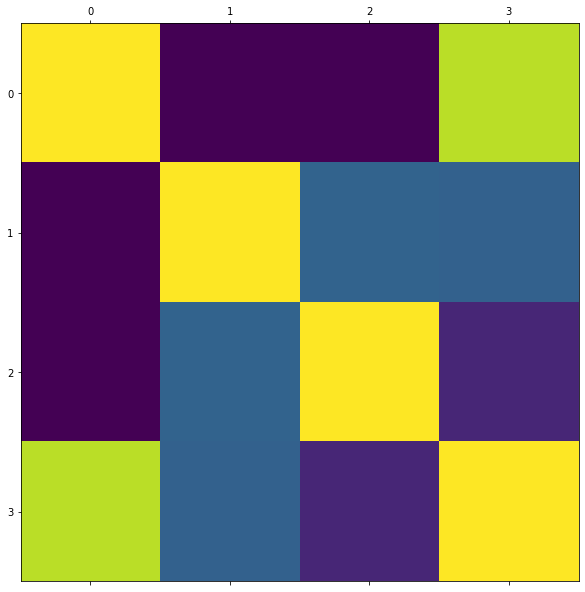

In [59]:
import matplotlib.pyplot as plt

plt.matshow(df.corr())
plt.show()